#### 07/30/23

#### Joshua Edelstein

# Loan Default

## Overview
background on loans, and banks offering them, and defaulting on loans

## Business Understanding
Bank XYZ is smaller end bank who has a good customer base but is struggling with loan defaults ... 
False positive(precision) predict pay back when wont vs false negative(recall) predict wont pay back when do. here precision is more important bc its worse to lose money from a loan, then to turn away a customer.

<div>
<img src="Images/inside_bank1.jpg", width = 800, height = 400/>
</div>

## Data Understanding

data source and background: https://www.kaggle.com/datasets/mirbektoktogaraev/should-this-loan-be-approved-or-denied

Let's do some EDA to find out more about are data. We'll begin by importing all the necessary packages, load our data into a pandas dataframe and preview the first 5 rows


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Filtering future warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix

from imblearn.under_sampling import RandomUnderSampler

import folium

In [2]:
data = pd.read_csv('data/SBAnational.csv')

In [3]:
loan_df = data.copy()

In [4]:
loan_df.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


Now let's take a look at all the columns

In [5]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LoanNr_ChkDgt      899164 non-null  int64  
 1   Name               899150 non-null  object 
 2   City               899134 non-null  object 
 3   State              899150 non-null  object 
 4   Zip                899164 non-null  int64  
 5   Bank               897605 non-null  object 
 6   BankState          897598 non-null  object 
 7   NAICS              899164 non-null  int64  
 8   ApprovalDate       899164 non-null  object 
 9   ApprovalFY         899164 non-null  object 
 10  Term               899164 non-null  int64  
 11  NoEmp              899164 non-null  int64  
 12  NewExist           899028 non-null  float64
 13  CreateJob          899164 non-null  int64  
 14  RetainedJob        899164 non-null  int64  
 15  FranchiseCode      899164 non-null  int64  
 16  Ur

We see that this is a very large dataframe, with around 900,000 rows and 26 columns. The column `MIS_Status` is our target column, which indicates whether the loan was paid back or not. We can also see that our dataframe has a solid amount of both int and object types. Being that many of many of the columns are in the wrong format, and have the wrong datatype we will need to perform some cleaning before we do our EDA

## Preprocessing
Let's start with the date values, which include: `ApprovalDate`, which is the date the loan was approved; `DisbursmentDate`, the date the loan was actually given; `ChgOffDate` which is the date the loan was declared in default. Let's format these properly by turning them into datetime.

In [6]:
#code from: https://www.kaggle.com/code/ricardocolindres/loan-default-prediction-loan-parameter-optimizer
# pandas will assume all years that are only the last 2 digits are after 2000. 
#So we need to reformat the year
def get_date(x):
    if type(x) == float:
        return None
    else:
        date = x.split('-')
        year = date[2] 
        if year == '00':
            year = '20' + year
        elif year == '20':
            year = '20' + '00'
        elif int(year) > 20:
            year = '19' + year
        else:
            year = '20' + year
        return f'{date[0]}-{date[1]}-{year}'

# Convert datetime fields into proper data type and apply get_date function
loan_df['approval_date'] = pd.to_datetime(loan_df['ApprovalDate'].apply(get_date))
loan_df['disbursement_date'] = pd.to_datetime(loan_df['DisbursementDate'].apply(get_date))
loan_df['chg_off_date'] = pd.to_datetime(loan_df['ChgOffDate'].apply(get_date))

In [7]:
#sample the new columns
print(loan_df['approval_date'].head())
print(loan_df['disbursement_date'].head())
print(loan_df['chg_off_date'].head())

0   1997-02-28
1   1997-02-28
2   1997-02-28
3   1997-02-28
4   1997-02-28
Name: approval_date, dtype: datetime64[ns]
0   1999-02-28
1   1997-05-31
2   1997-12-31
3   1997-06-30
4   1997-05-14
Name: disbursement_date, dtype: datetime64[ns]
0   NaT
1   NaT
2   NaT
3   NaT
4   NaT
Name: chg_off_date, dtype: datetime64[ns]


All of the columns look good. Being that most of the `chg_off_date` columns are null that result also makes sense. 

For all the rows the disbursement date must be after the date the loan was approved, let's confirm if this is true

In [8]:
#create boolean values if disbursement date is later
loan_df['is_disbursement_later'] = loan_df['disbursement_date'] >= loan_df['approval_date']

#print value counts normally and as percentages
print(loan_df['is_disbursement_later'].value_counts())
print(loan_df['is_disbursement_later'].value_counts(normalize=True) * 100)

is_disbursement_later
True     895987
False      3177
Name: count, dtype: int64
is_disbursement_later
True     99.646672
False     0.353328
Name: proportion, dtype: float64


We see that there are some rows where the disbursement date was earlier. Since it's such a small percentage of the overall data, let's go ahead and drop those rows, as there may be additional input inaccuracies.

In [9]:
#drop rows with earlier disbursement date
loan_df = loan_df[loan_df['disbursement_date'] >= loan_df['approval_date']]
len(loan_df)

895987

Being that we in certain cases it may be easier to work with years for modeling, let's pull out the year from the `approved_year` column as well as the `disbursement_date` and `chg_off_date` columns.

In [10]:
# Get the year from approval_date and chg_off_date
loan_df['approval_year'] = loan_df['approval_date'].apply(lambda x: int(x.year))
loan_df['disbursement_year'] = loan_df['disbursement_date'].apply(lambda x: int(x.year))
loan_df['chg_off_year'] = loan_df['chg_off_date'].apply(lambda x: int(x.year) if not x is pd.NaT else None).astype('Int64')

Now let's drop all the columns we for sure don't need at this point.

In [11]:
loan_df = loan_df.drop(['DisbursementDate', 'ApprovalDate',
                        'ChgOffDate', 'ApprovalFY', 'is_disbursement_later'], axis=1) 

Now let's create a column to see the date and year when each of the loans were due.

In [12]:
#add the Term of the loan to the disbursement date to get the date when the loan was due
loan_df['loan_maturity_date'] = loan_df.apply(lambda x: x['disbursement_date'] + 
                                    pd.DateOffset(months = x['Term']), axis=1)
# Get loan maturity year
loan_df['loan_maturity_year'] = loan_df['loan_maturity_date'].dt.year.astype('Int64')

Since the dataset only goes till 2014, all loans that are due beyond 2014 will appear to be paid back eventhough they really have not been tracked. As such we will drop all those that extend beyond 2014, except for the ones that have already defaulted.

In [13]:
#calculate length of loan_df before the drop
original_length = len(loan_df)
#drop loans that status is Paid in Full yet extend beyond 2014
loan_df = loan_df.drop(loan_df[(loan_df['MIS_Status'] == 'P I F') & (loan_df['loan_maturity_year'] > 2014)].index)

# Loans that have no default status and extend beyond 2014 will also be dropped.
loan_df = loan_df.drop(loan_df[(loan_df['MIS_Status'].isnull()) & (loan_df['loan_maturity_year'] > 2014)].index) #242 dicarded
loan_df.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,...,GrAppv,SBA_Appv,approval_date,disbursement_date,chg_off_date,approval_year,disbursement_year,chg_off_year,loan_maturity_date,loan_maturity_year
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,84,4,...,"$60,000.00","$48,000.00",1997-02-28,1999-02-28,NaT,1997,1999,<NA>,2006-02-28,2006
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,60,2,...,"$40,000.00","$32,000.00",1997-02-28,1997-05-31,NaT,1997,1997,<NA>,2002-05-31,2002
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,180,7,...,"$287,000.00","$215,250.00",1997-02-28,1997-12-31,NaT,1997,1997,<NA>,2012-12-31,2012
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,60,2,...,"$35,000.00","$28,000.00",1997-02-28,1997-06-30,NaT,1997,1997,<NA>,2002-06-30,2002
5,1000084002,"B&T SCREW MACHINE COMPANY, INC",PLAINVILLE,CT,6062,"TD BANK, NATIONAL ASSOCIATION",DE,332721,120,19,...,"$517,000.00","$387,750.00",1997-02-28,1997-06-30,NaT,1997,1997,<NA>,2007-06-30,2007


In [14]:
print(f'We dropped: {original_length - len(loan_df)} rows')
print(f'Our new loan_df shape is {loan_df.shape}')

We dropped: 197957 rows
Our new loan_df shape is (698030, 31)


Now let's check out what other columns need to be cleaned.

In [15]:
loan_df.isna().sum()

LoanNr_ChkDgt              0
Name                      12
City                      30
State                     13
Zip                        0
Bank                    1458
BankState               1465
NAICS                      0
Term                       0
NoEmp                      0
NewExist                  40
CreateJob                  0
RetainedJob                0
FranchiseCode              0
UrbanRural                 0
RevLineCr               3344
LowDoc                  1482
DisbursementGross          0
BalanceGross               0
MIS_Status              1561
ChgOffPrinGr               0
GrAppv                     0
SBA_Appv                   0
approval_date              0
disbursement_date          0
chg_off_date          536030
approval_year              0
disbursement_year          0
chg_off_year          536030
loan_maturity_date         0
loan_maturity_year         0
dtype: int64

The count of missing values in `chg_off_date` and `chg_off_year` seem to have NaN values in all the rows that didn't default on their loans; since this is most of the dataframe this is not very useful. As such, let's create a new dataframe with only time related columns for our eda and then drop the `chg_off_date` and `chg_off_year`. Let's also drop all the other rows that contain null values being that they make up such a small percentage of our data.

In [16]:
time_df = loan_df[['chg_off_date', 'chg_off_year', 'approval_date', 
                   'approval_year', 'disbursement_date', 'disbursement_year']].copy()
time_df.head(2)

,chg_off_date,chg_off_year,approval_date,approval_year,disbursement_date,disbursement_year
0,NaT,<NA>,1997-02-28,1997,1999-02-28,1999
1,NaT,<NA>,1997-02-28,1997,1997-05-31,1997


In [17]:
loan_df.drop(columns=['chg_off_date', 'chg_off_year'], axis=1, inplace=True)

In [18]:
#drop null in all
loan_df = loan_df.dropna()
loan_df.isna().sum().sum()

0

Now that there are no NaN values in our loan_df, the next step is to look through all the columns and make sure that they are ready for modeling. First, we will make sure that they are the right data type. Then we will make sure there are no filler values in them. Finally, we will decide if there is a better way to group the data. After looking through all the data we have made a plan of what needs to be done, that I will map out:

Note: that for all of these columns, I seperately pulled up the value counts so none of it is in this notebook.
   - Being that the `LoanNr_ChkDgt` column is the id, we will need to change that to object type. 
   -  Being that `City` and `Zip` contain over 28,000 values with no great way to combine them, we will keep these columns for EDA and then drop them for the modeling. We will need to change the datatype on `Zip` to a string.
   - `State` needs to be broken into dummy rows for the modeling.
   - `Bank` has 5440 different values, we will regroup this column into a few columns based on value counts, and later one hot encode the column for modeling. 
       - If there are more than 10000 value counts(vcs) of a certain bank we will say the bank is Huge(12 counts)
        - If more than 1000 vcs then very_large(58 counts),
        - If more than 100 we'll say large(~500).
        - If more than 25 then small(~1000),
        - If more than 5 then very_small(~1600),
        - Below 5(~2200) then tiny.
   - `BankState`, has 5 states that appear less than 1000 times, so we will combine them as `other`. Later we will OHE the column for modeling.
   - `NAICS` is a classification code for the business so this will also be changed to object. Additionally only the first 2 digits are important. Of which certain values mean the same thing. So we also need to create a dictionary to rename the values. Later we will get dummy columns for the whole column.
   - `Term` which is the loan length in months will be converted to years.
   - `NoEmp` which describes the number of employees will remain the same.
   - `NewExist` contains only 1s and 2s whether the business is existing or new. So we'll rename the column `Existing`, and change this to a boolean value, all values that are not 1 or 2 we will drop those rows(only 702 rows).
   - `CreateJob` and `RetainJob` give information about the number of jobs created and retained, these will remain the same.
   - `FranchiseCode` contains the franchise codes, the codes 00000 and 00001 means that its not a franchise. Being that the vast majority of the values are not a franchise, we will convert this column to a boolean if it's a franchise.
   - `UrbanRural` contains a 0,1 or 2 if its undefined, urban or rural. We will rename the values based on its true meaning, then we will fill the undefined values based on zipcode using a csv of urban rural codes per zipcode.
   - `RevLineCr` states whether the business has a revolving line of credit, the values are str Y or N. We will switch these to boolean values, and try to find the best way to fill the other values
   - `LowDoc` says whether the loan was from the LowDoc Loan Program. This program is a specific loan program that was offered by the Small Business Administration in the United States. It was designed to streamline the loan application process for small businesses by requiring less documentation compared to traditional loan programs. This column also contains Y and N, as such we will switch it to boolean values. We will drop all rows that are not Y or N(around 1500 rows).
   - `MIS_Status` is our target column whether the loan was paid in full or defaulted, as such we will rename the column `Paid` and then change it to boolean values.
   - The last 5 columns all contain monetary amounts with dollar signs, commas, and periods, as such they are stored as a str. We will reformat them as int values.
   - `DisbursementGross` contains the amount given.
   - `BalanceGross` contains the gross amount that is still due, being that there are less than 10 rows that dont contain 0, let's drop this column.
   - `ChgOffPrinGr` represents the amount of debt that the lender considers unlikely to be fully repaid and removes it from their active accounts receivable. 
   - `GrAppv` column indicates the gross amount of money that a bank or lending institution has approved to lend to a borrower. 
   - `SBA_Appv` column indicates the specific amount that the Small Business Administration guarantees to pay back, should the borrower not.

For the first step in out cleaning let's change all the columns that are need to be stored as strings into strings. This includes the `LoanNr_ChkDgt`, and `NAICS` column.

In [19]:
#make a list of columns to change data type
cols = ['LoanNr_ChkDgt', 'NAICS', 'Zip']

#create a for loop to change the dtypes of each to string
for col in cols:
    loan_df[col] = loan_df[col].astype(str)

#sample NAICS
loan_df.Zip.dtype

dtype('O')

Now that we have already begun the cleaning on the `NAICS` column, let's finish it up. First, we'll strip all but the first 2 numbers, as they are the only important ones. Next, we will create a dictionary to rename the values based on the general category in which they fall.

In [20]:
#ONLY RUN THIS ONCE
#pull out only the first 2 digits
loan_df['NAICS'] = loan_df['NAICS'].str.slice(stop=2)

In [21]:
#use dictionary to rename and store values together
rename_dict = {
    '0': 'Unidentified',
    '11': 'Agriculture',
    '21': 'Mining',
    '22': 'Utilities',
    '23': 'Construction',
    '31': 'Manufacturing',
    '32': 'Manufacturing',
    '33': 'Manufacturing',
    '42': 'Wholesale',
    '44': 'Retail',
    '45': 'Retail',
    '48': 'Transportation_Warehousing',
    '49': 'Transportation_Warehousing',
    '51': 'Information',
    '52': 'Finance_Insurance',
    '53': 'Real_Estate',
    '54': 'Professional_services',
    '55': 'Management',
    '56': 'Administration_service',
    '61': 'Education',
    '62': 'Health_care',
    '71': 'Arts',
    '72': 'Accomodation_Food',
    '81': 'Other_services',
    '92': 'Public_administration'
}

loan_df['NAICS'] = loan_df['NAICS'].replace(rename_dict)

loan_df.NAICS.value_counts()

NAICS
Unidentified                  160213
Retail                        100358
Other_services                 54754
Construction                   53286
Professional_services          52284
Manufacturing                  50790
Accomodation_Food              45081
Wholesale                      37786
Health_care                    37755
Administration_service         27404
Transportation_Warehousing     18594
Arts                           10692
Real_Estate                    10431
Information                     9440
Finance_Insurance               7178
Agriculture                     6843
Education                       4860
Mining                          1494
Utilities                        559
Public_administration            200
Management                       104
Name: count, dtype: int64

Next we will work on the `Bank` column. We will rename each value based on the amount of value counts in the dataframe. We'll break it down as we listed above.

In [22]:
# create ranges of value counts to relabel values
def map_bank(count):
    if count >= 10000:
        return 'huge'
    elif 1000 <= count < 10000:
        return 'very_large'
    elif 100 <= count < 1000:
        return 'large'
    elif 25 <= count < 100:
        return 'small'
    elif 5 <= count < 25:
        return 'very_small'
    else:
        return 'tiny'
    
# create function to apply the mapping function to desired column column
def rename_w_vcs(loan_df, column, vc_map):
    # create dictionary of value counts
    column_dict = loan_df[column].value_counts().to_dict()
    #replace bank name with value count, then replace count with new name
    loan_df[column] = loan_df[column].map(column_dict).map(vc_map)
    return loan_df

In [23]:
rename_w_vcs(loan_df, 'Bank', map_bank)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,...,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,approval_date,disbursement_date,approval_year,disbursement_year,loan_maturity_date,loan_maturity_year
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,very_large,OH,Retail,84,4,...,P I F,$0.00,"$60,000.00","$48,000.00",1997-02-28,1999-02-28,1997,1999,2006-02-28,2006
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,large,IN,Accomodation_Food,60,2,...,P I F,$0.00,"$40,000.00","$32,000.00",1997-02-28,1997-05-31,1997,1997,2002-05-31,2002
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,very_small,IN,Health_care,180,7,...,P I F,$0.00,"$287,000.00","$215,250.00",1997-02-28,1997-12-31,1997,1997,2012-12-31,2012
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,small,OK,Unidentified,60,2,...,P I F,$0.00,"$35,000.00","$28,000.00",1997-02-28,1997-06-30,1997,1997,2002-06-30,2002
5,1000084002,"B&T SCREW MACHINE COMPANY, INC",PLAINVILLE,CT,6062,very_large,DE,Manufacturing,120,19,...,P I F,$0.00,"$517,000.00","$387,750.00",1997-02-28,1997-06-30,1997,1997,2007-06-30,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899159,9995573004,FABRIC FARMS,UPPER ARLINGTON,OH,43221,huge,IL,Retail,60,6,...,P I F,$0.00,"$70,000.00","$56,000.00",1997-02-27,1997-09-30,1997,1997,2002-09-30,2002
899160,9995603000,FABRIC FARMS,COLUMBUS,OH,43221,huge,IL,Retail,60,6,...,P I F,$0.00,"$85,000.00","$42,500.00",1997-02-27,1997-10-31,1997,1997,2002-10-31,2002
899161,9995613003,"RADCO MANUFACTURING CO.,INC.",SANTA MARIA,CA,93455,very_large,CA,Manufacturing,108,26,...,P I F,$0.00,"$300,000.00","$225,000.00",1997-02-27,1997-09-30,1997,1997,2006-09-30,2006
899162,9995973006,"MARUTAMA HAWAII, INC.",HONOLULU,HI,96830,very_large,HI,Unidentified,60,6,...,CHGOFF,"$46,383.00","$75,000.00","$60,000.00",1997-02-27,1997-03-31,1997,1997,2002-03-31,2002


In [24]:
#check that it worked
print(loan_df.Bank.value_counts())

Bank
huge          297228
very_large    181716
large         138535
small          47610
very_small     20950
tiny            4067
Name: count, dtype: int64


Great, we see that since the 12 biggest banks represented most values, they are now the largest value counts. Although there were many banks with less than 5 value counts since they appear so few times they represent a very small portion of the data. 

Now, let's replace the last few value counts in `BankState` with `other`.

In [25]:
#create dict to replace values
bankstate_dict = {'PR': 'other',
                  'GU': 'other',
                  'AN': 'other',
                  'EN': 'other',
                  'VI': 'other'}

#replace values based on dict
loan_df['BankState'] = loan_df['BankState'].replace(bankstate_dict)

#preview the results
loan_df.BankState.value_counts().tail(5)

BankState
AZ       2051
WY       1727
WV       1720
AK       1306
other     145
Name: count, dtype: int64

Let's convert the `Term` column from months to years by dividing by 12

In [26]:
loan_df['Term'] = loan_df['Term']/12

Now let's create a new column that is a boolean if the business recieving the loan is a francise, and we will drop the old column.

In [27]:
#change the 1 to a 0 and keep the 0 as 0. Change all other values to a 1. Rename the column
loan_df['is_franchise'] = loan_df['FranchiseCode'].apply(lambda x: 0 if x in (0,1) else 1)

#Drop the old row
loan_df.drop(columns='FranchiseCode', axis=1, inplace=True)

#confirm it worked
loan_df.is_franchise.value_counts()

is_franchise
0    651851
1     38255
Name: count, dtype: int64

Now we will move on to check out our other columns that should only contain 2 values. This includes: `NewExist`, `RevLineCr`, `LowDoc`,`MIS_Status`, and `UrbanRural`. In theory all these columns should contain 2 values. Let's see if this is indeed the case.

In [28]:
boolean_cols = ['NewExist', 'RevLineCr', 'LowDoc', 'MIS_Status', 'UrbanRural']

[loan_df[col].value_counts() for col in boolean_cols]

[NewExist
 1.0    488292
 2.0    201112
 0.0       702
 Name: count, dtype: int64,
 RevLineCr
 N    315015
 0    183988
 Y    177585
 T     13470
 R        14
 1        13
 `         9
 2         5
 C         2
 ,         1
 7         1
 .         1
 -         1
 Q         1
 Name: count, dtype: int64,
 LowDoc
 N    586215
 Y    102078
 0       611
 C       455
 S       360
 A       341
 R        46
 Name: count, dtype: int64,
 MIS_Status
 P I F     534130
 CHGOFF    155976
 Name: count, dtype: int64,
 UrbanRural
 1    357079
 0    258452
 2     74575
 Name: count, dtype: int64]

For `NewExist` and `LowDoc` the vast majority of the values are are 1 and 2 or Y and N. Since we already dropped the null values in the `MIS Status` column, all the values fall into 2 categories. Being that `RevLineCr` and `UrbanRural` have a significant amount of rows with unclear values we will have to find a way to deal with those values. For now let's create a function that take in a loan_df, column, value to store as 1, and value to store as 0, list of new column name and converts the columns into boolean values, for everthing not in that list store is as a null value

In [29]:
#create function that takes in loan_df, col name, current T, current F, and new column name
def convert_to_bool(loan_df, col_name, T_value, F_value, new_col_name):
    #use apply with lambda to replace values in each row with 0,1 or nan
    loan_df[new_col_name] = loan_df[col_name].apply(lambda x: 1 if x==T_value 
                                          else(0 if x==F_value else np.nan))

In [30]:
#create list of old_cols, new_col_names, current T values, current F values
old_cols = ['NewExist', 'RevLineCr', 'LowDoc', 'MIS_Status', 'UrbanRural', 'RevLineCr']
new_col_names = ['Existing', 'Rev_credit_line', 'Low_doc_loan', 'Paid', 
                 'Urban', 'Rev_credit_line']
true_values = [1.0, 'Y', 'Y', 'P I F', 1, 'Y']
false_values = [2.0, 'N', 'N', 'CHGOFF', 2, 'N']

#use zip and run a for loop with function to achieve all at once
for col_name, T_value, F_value, new_col_name in zip(old_cols, true_values, 
                                                    false_values, new_col_names):
    convert_to_bool(loan_df, col_name, T_value, F_value, new_col_name)

#preview new cols
loan_df[new_col_names].head()  

,Existing,Rev_credit_line,Low_doc_loan,Paid,Urban,Rev_credit_line
0,0.0,0.0,1.0,1,NaN,0.0
1,0.0,0.0,1.0,1,NaN,0.0
2,1.0,0.0,0.0,1,NaN,0.0
3,1.0,0.0,1.0,1,NaN,0.0
5,1.0,0.0,0.0,1,NaN,0.0


Now let's go ahead and drop the old columns as well as the nan columns in `Existing` and `Low_doc_loan` column. 

In [31]:
#drop old columns
loan_df.drop(columns=['NewExist', 'RevLineCr', 'LowDoc', 'MIS_Status', 'UrbanRural'], 
        axis=1, inplace=True)

#drop nan rows in Existing and Low_doc_loan column
og_len = len(loan_df)
loan_df.dropna(subset=['Existing', 'Low_doc_loan'], inplace=True)
print(f'We dropped {og_len - len(loan_df)} rows. Our loan_df is now {len(loan_df)} rows long.')

We dropped 2510 rows. Our loan_df is now 687596 rows long.


In [32]:
#CHECKPOINT. DELETE AT THE END
fr = loan_df.copy()
# loan_df = fr.copy()

Let's now fill the missing values in `UrbanRural`. We were able to obtain a breakdown of Urban and Rural by zipcode from https://www.ers.usda.gov/data-products/rural-urban-commuting-area-codes/. The data cleaning was done in in a different notebook. Let's load up the csv here.

In [33]:
#load csv as pd dataframe
urban_map = pd.read_csv('data/urban_codes.csv')
urban_map.head()

,RUCA1,Zip
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5


It seems that the leading zeros in zipcode got lost in the transition. Let's fill those strings with zeros.

In [34]:
#fill the zipcode column with leading zeros
urban_map['Zip'] = urban_map['Zip'].astype(str).str.zfill(5)

#preview
urban_map.head()

,RUCA1,Zip
0,0,00001
1,0,00002
2,0,00003
3,0,00004
4,0,00005


Now we will join the two dataframes together on the `Zip` column. We want to include all the rows from the `loan_df`, and only the corresponding rows from the `urban_map` loan_df. As such we will do a left join.

In [35]:
#now lets merge the dataframes with a left merge
loan_df = loan_df.merge(urban_map, on='Zip', how='left')
loan_df.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,...,disbursement_year,loan_maturity_date,loan_maturity_year,is_franchise,Existing,Rev_credit_line,Low_doc_loan,Paid,Urban,RUCA1
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,very_large,OH,Retail,7.0,4,...,1999,2006-02-28,2006,0,0.0,0.0,1.0,1,NaN,1.0
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,large,IN,Accomodation_Food,5.0,2,...,1997,2002-05-31,2002,0,0.0,0.0,1.0,1,NaN,1.0
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,very_small,IN,Health_care,15.0,7,...,1997,2012-12-31,2012,0,1.0,0.0,0.0,1,NaN,1.0
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,small,OK,Unidentified,5.0,2,...,1997,2002-06-30,2002,0,1.0,0.0,1.0,1,NaN,1.0
4,1000084002,"B&T SCREW MACHINE COMPANY, INC",PLAINVILLE,CT,6062,very_large,DE,Manufacturing,10.0,19,...,1997,2007-06-30,2007,0,1.0,0.0,0.0,1,NaN,NaN


Now let's fill the `Urban` column with the corresponding value in the `RUCA1` column, which represents whether the zip code is Urban.

In [36]:
#fill Urban col with RUCA1 values
loan_df['Urban'].fillna(loan_df['RUCA1'], inplace=True)

#drop the RUCA1 column
loan_df.drop('RUCA1', axis=1, inplace=True)

#preview results
loan_df.Urban.value_counts(dropna=False)

Urban
1.0    569029
0.0     84408
NaN     34159
Name: count, dtype: int64

We just went from 256940 null values to only 34159! 
Now we have to decide what we want to do with the rest of these null values. As well as the null values from the `Rev_credit_line` column. Let's pull up the percentages for each and then decide how to handle them.

In [37]:
#set value counts as percentage
urban_counts = loan_df.Urban.value_counts(dropna=False, normalize=True)
rev_counts = loan_df.Rev_credit_line.value_counts(dropna=False, normalize=True)

#print percent null counts
print('Urban null percentage : ', round(urban_counts.get(np.nan) * 100, 2))
print('Revolving credit line null percentage : ', round(rev_counts.get(np.nan) * 100, 2))

Urban null percentage :  4.97
Revolving credit line null percentage :  28.66


Since we have such a large dataframe and the null counts in the `Urban` column represent such a small percentage of the data lets drop those rows

In [38]:
#drop null values in Urban column
loan_df.dropna(subset=['Urban'], inplace=True)

#preview null values in column
loan_df.Urban.isna().sum()

0

Since we are only dealing with EDA, and our fill method on `Rev_credit_line` will end up being some sort of educated guess let's move on from the column for now and finish our required cleaning for the last few columns. All of the columns: `DisbursementGross`, `ChgOffPrinGr`, `GrAppv`, and `SBA_Appv`, are number amounts but stored as a string with a dollar sign, commas and periods. As such we will strip all the punctuation and store it as a int. We will first drop the `BalanceGross` column

In [39]:
loan_df = loan_df.drop('BalanceGross', axis=1)

In [40]:
#columns to convert
strip_columns = ['DisbursementGross', 'ChgOffPrinGr', 'GrAppv','SBA_Appv']

#remove all punctuation that isn't a period, and store it as float
for col in strip_columns:
    loan_df[col] = loan_df[col].str.replace(r'[^\d.]', '', regex=True).astype(float)
    
#preview results
loan_df['DisbursementGross'].head()

0     60000.0
1     40000.0
2    287000.0
3     35000.0
6     45000.0
Name: DisbursementGross, dtype: float64

We will now reset the index, and preview our columns to confirm that we are are ready for our EDA

In [41]:
#reset index
loan_df.reset_index(drop=True, inplace=True)

#preview columns
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653437 entries, 0 to 653436
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   LoanNr_ChkDgt       653437 non-null  object        
 1   Name                653437 non-null  object        
 2   City                653437 non-null  object        
 3   State               653437 non-null  object        
 4   Zip                 653437 non-null  object        
 5   Bank                653437 non-null  object        
 6   BankState           653437 non-null  object        
 7   NAICS               653437 non-null  object        
 8   Term                653437 non-null  float64       
 9   NoEmp               653437 non-null  int64         
 10  CreateJob           653437 non-null  int64         
 11  RetainedJob         653437 non-null  int64         
 12  DisbursementGross   653437 non-null  float64       
 13  ChgOffPrinGr        653437 no

Everything looks good, now let's begin our EDA

## EDA
Let's begin by seeing where across the country our data is from:
zip long lat file: https://gist.github.com/erichurst/7882666#file-us-zip-codes-from-2013-government-data

We will need to bring in the longitude and latitude from a different internet file with zipcodes and this information. First let's make an EDA dataframe which will be a copy of our loan dataframe

In [137]:
#perform eda on a copy
eda_df = loan_df.copy()

In [138]:
file = pd.read_csv('data/zip_long_lat.csv')

In [139]:
all_zip_df = file.copy()

all_zip_df.head()

,ZIP,LAT,LNG
0,601,18.180555,-66.749961
1,602,18.361945,-67.175597
2,603,18.455183,-67.119887
3,606,18.158345,-66.932911
4,610,18.295366,-67.125135


Again, we need to fill in the leading 0s

In [140]:
#fill leading spaces with 0s
all_zip_df['ZIP'] = all_zip_df['ZIP'].astype(str).str.zfill(5)

#rename column for easier join
all_zip_df.rename(columns={'ZIP':'Zip'}, inplace=True)

#preview
all_zip_df.Zip.head()

0    00601
1    00602
2    00603
3    00606
4    00610
Name: Zip, dtype: object

In [141]:
#create df with only our zipcodes
our_zip_df = eda_df[['Zip']]
#fill leading zeros
our_zip_df.Zip = our_zip_df.Zip.str.zfill(5)
#preview
print(len(our_zip_df))
our_zip_df[141213:141216]

653437


,Zip
141213,05401
141214,75075
141215,76180


In [142]:
#join dfs to make new zip df 
zip_df = our_zip_df.join(other=all_zip_df.set_index('Zip'), on='Zip', how='left')
#preview: it shud be 653437
print(len(zip_df))
print(zip_df[141213:141216])
zip_df.isna().sum()

653437
          Zip        LAT        LNG
141213  05401  44.476621 -73.209998
141214  75075  33.021268 -96.741558
141215  76180  32.840011 -97.225295


Zip       0
LAT    6865
LNG    6865
dtype: int64

let's look at some of the null values

In [143]:
#create mask to get null values
rows_with_null_mask = zip_df.isnull().any(axis=1)

#create sample of null values
rows_with_null_sample = zip_df[rows_with_null_mask].sample(n=15, random_state=42)

#print them
rows_with_null_sample

,Zip,LAT,LNG
213846,95852,NaN,NaN
179320,95433,NaN,NaN
243420,35236,NaN,NaN
429695,85222,NaN,NaN
456800,32248,NaN,NaN
208354,90707,NaN,NaN
593650,07653,NaN,NaN
309649,17001,NaN,NaN
484995,81814,NaN,NaN
229931,92680,NaN,NaN


Since the spread of null values seems random, we are only using this dataframe for eda, and our dataframe is so large, let's drop all the rows with null values.

In [144]:
#drop nulls
zip_df.dropna(inplace=True)

#check new length
len(zip_df)

646572

In [160]:
#drop everything with long over -65, as it is 3 datapoint(guam and caribbean islands)
no_guam_df = zip_df[zip_df.LNG < -65]

In [166]:
#drop hawaii and alaska
states48_df = zip_df[(zip_df.LNG>-128) & (zip_df.LAT>20)]
hawaii_df = zip_df[(zip_df.LAT<30) & (zip_df.LNG<-140)]
alaska_df = zip_df[(zip_df.LAT>50) & (zip_df.LNG<-120)]

Now let's map the zipcodes

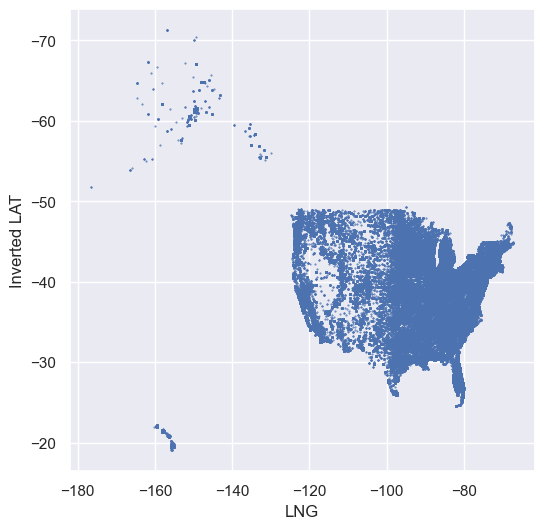

In [168]:
plt.scatter(x=no_guam_df['LNG'], y=-no_guam_df['LAT'], s=0.2)
plt.xlabel('LNG')
plt.ylabel('Inverted LAT')  
plt.gca().invert_yaxis()
plt.show()

In [173]:
records = []
for index, row in zip_df.iterrows():
    record = {
        'zip' : row['Zip'],
        'longitude' : row['LNG'],
        'latitude' : row['LAT']
    }
    records.append(record)

In [174]:
records[0]

{'zip': '47711', 'longitude': -87.536743, 'latitude': 38.015301}

In [183]:
my_map = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

my_map

Next let's check out the spread of our data.

In [45]:
#pull up descriptive stats
eda_df.describe()  

,Term,NoEmp,CreateJob,RetainedJob,DisbursementGross,ChgOffPrinGr,GrAppv,SBA_Appv,approval_date,disbursement_date,approval_year,disbursement_year,loan_maturity_date,loan_maturity_year,is_franchise,Existing,Rev_credit_line,Low_doc_loan,Paid,Urban
count,653437.000000,653437.000000,653437.000000,653437.000000,6.534370e+05,6.534370e+05,6.534370e+05,6.534370e+05,653437,653437,653437.000000,653437.000000,653437,653437.0,653437.000000,653437.000000,462982.000000,653437.000000,653437.000000,653437.000000
mean,6.810641,10.168529,8.949822,11.404423,1.412631e+05,1.786033e+04,1.300816e+05,9.630162e+04,2001-04-19 01:25:12.173323392,2001-07-26 04:49:25.495985280,2000.799679,2001.041123,2008-05-17 16:20:04.603963392,2007.85065,0.055675,0.707987,0.380306,0.143341,0.766493,0.870825
min,0.000000,0.000000,0.000000,0.000000,4.000000e+03,0.000000e+00,1.000000e+03,5.000000e+02,1969-04-28 00:00:00,1969-05-22 00:00:00,1969.000000,1969.000000,1973-11-03 00:00:00,1973.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.833333,2.000000,0.000000,0.000000,3.500000e+04,0.000000e+00,2.850000e+04,1.700000e+04,1997-01-24 00:00:00,1997-06-30 00:00:00,1997.000000,1997.000000,2005-03-31 00:00:00,2005.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,7.000000,4.000000,0.000000,1.000000,7.500000e+04,0.000000e+00,6.000000e+04,4.250000e+04,2003-01-15 00:00:00,2003-03-31 00:00:00,2003.000000,2003.000000,2009-06-30 00:00:00,2009.0,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,7.000000,9.000000,1.000000,4.000000,1.500000e+05,0.000000e+00,1.500000e+05,1.125000e+05,2005-11-04 00:00:00,2006-01-31 00:00:00,2005.000000,2006.000000,2012-03-31 00:00:00,2012.0,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,36.500000,9999.000000,8800.000000,8800.000000,1.144632e+07,3.512596e+06,5.000000e+06,4.500000e+06,2014-06-23 00:00:00,2014-06-23 00:00:00,2014.000000,2014.000000,2035-07-30 00:00:00,2035.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,4.133027,75.257499,256.703715,256.830938,2.089812e+05,7.465034e+04,1.964853e+05,1.507037e+05,NaN,NaN,5.768067,5.676075,NaN,5.231899,0.229293,0.454689,0.485463,0.350420,0.423062,0.335394


We will now discuss some our findings:

- The length of each loans ranges from 0 to 36.5 years, with most of the data falling between ~4-8, with a mean of 6.8.
- All the columns related to number of employees are skewed right with a large amount of companies having being 10 with a max above 8000.
- The disbursement amount column is also heavily skewed right, with a mean of around 141,000 thousand and median at 75,000. Most loans are between 35k and 150k. 
- Most businesses did previously exist before the loan; yet, were not franchises.
- Most businesses did not have a revolving line of credit, and most were urban.

Now let's graph some individual columns:

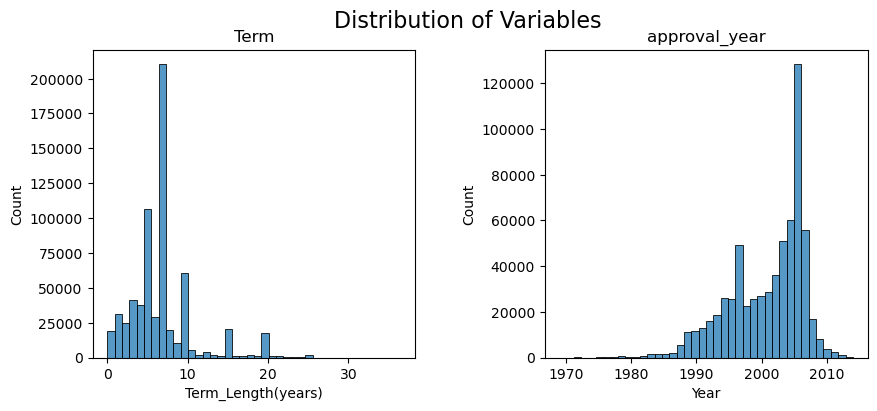

In [46]:
columns = ['Term', 'approval_year']
x_labels = ['Term_Length(years)', 'Year']

# Set figure size and create subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

#create for loop to plot both columns on a histogram. Label title and axes.
for i, col in enumerate(columns):
    sns.histplot(eda_df[col], bins=40, ax=axs[i])
    axs[i].set_title(col)
    axs[i].set_xlabel(x_labels[i])
    axs[i].set_ylabel('Count')  # Rename Y-axis
        
# Add a main title
fig.suptitle('Distribution of Variables', fontsize=16)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Show the plot
plt.show()

We see that the term lengths seem to have multiple peaks, the largest of which is around 7 years, with a count around 250,000. The others of which are at 1,3,5,10,15 and 20. The vast majority of loans for 10 years and under, with the longest being, for around 35 years.
The loans ranged from 1969 to 2014, with the majority being after 2000. This makes the dataset more helpful as the more recent the better. The peak of loans was slightly before 2010, with over 175,000 loans. The graph is somewhat normal and slightly skewed to the left.

Let's take a look at some other columns, relating to the loans that defaulted.

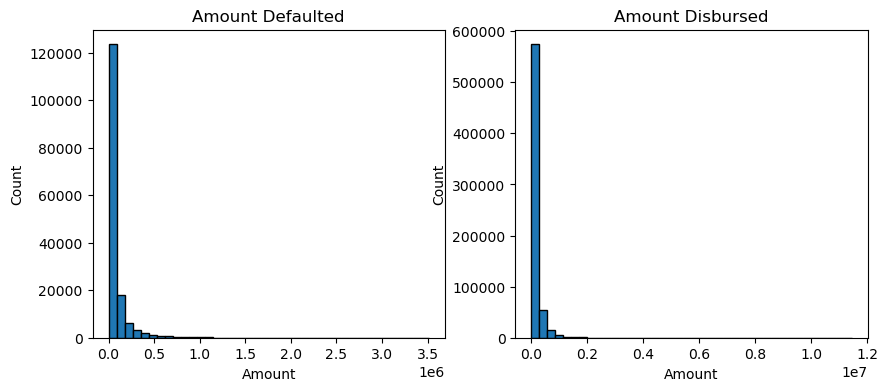

In [47]:
# Filter the 'ChgOffPrinGr' column to include only values greater than 0, and rename it
Defaulted_amount = eda_df[eda_df['ChgOffPrinGr'] > 0]['ChgOffPrinGr'].copy()
Defaulted_amount.rename('Amount Defaulted', inplace=True)

# Create a copy of the 'DisbursementGross' column and rename it 
Given_amount = eda_df['DisbursementGross'].copy()
Given_amount.rename('Amount Disbursed', inplace=True)

# Create figure and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, col in enumerate([Defaulted_amount, Given_amount]):
    # Create histogram and  set labels
    axs[i].hist(col, bins=40, edgecolor='black')
    axs[i].set_title(f'{col.name}')  # Use col.name as the title
    axs[i].set_xlabel('Amount')
    axs[i].set_ylabel('Count')

plt.show()

The vast majority of the values in the defaulted loans were below 100,000 dollars with decreasing still significant counts until around 600,000 dollars. There were very few counts above 1 million dollars, untill a max of around 3.5 million.
In terms of the amount given per loan it seems that most of them were below 50,000 dollars, and a small amount extended until 200,000 dollars. Above that there were very fews loans, and the max was 1.2 million.
Now let's begin to look into our target value: whether the loan was paid back. We will begin by creating a simple bar graph of the value counts per each.

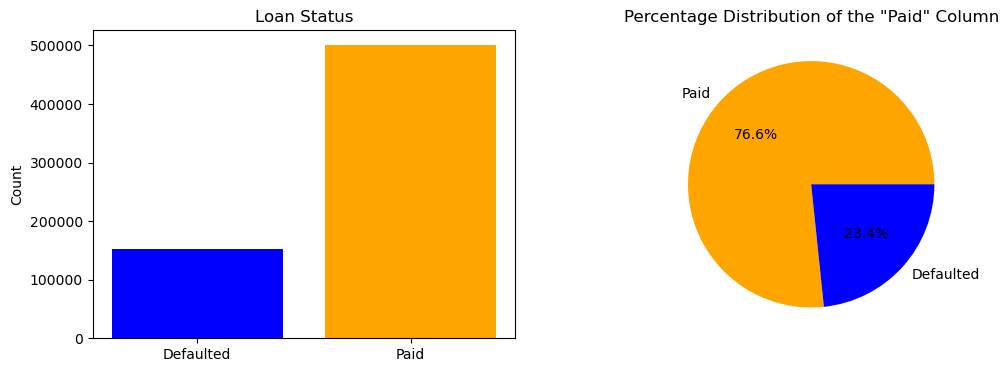

In [48]:
#get value counts
counts = eda_df['Paid'].value_counts()

# Set figure size and create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Set colors 
colors = ['orange', 'blue']

# Create bar
axes[0].bar(counts.index, counts.values, color=colors)

# Set labels and title for bar
axes[0].set_ylabel('Count')
axes[0].set_title('Loan Status')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Defaulted', 'Paid'])

# Create pie chart
axes[1].pie(counts, labels=['Paid', 'Defaulted'], colors=colors, autopct='%1.1f%%')

# Set title for pie chart
axes[1].set_title('Percentage Distribution of the "Paid" Column');


We see that this dataset is slightly imbalanced with a 76.6%(~500,000) to 23.4%(150,000) balance. This is something we may need to deal with later when modeling

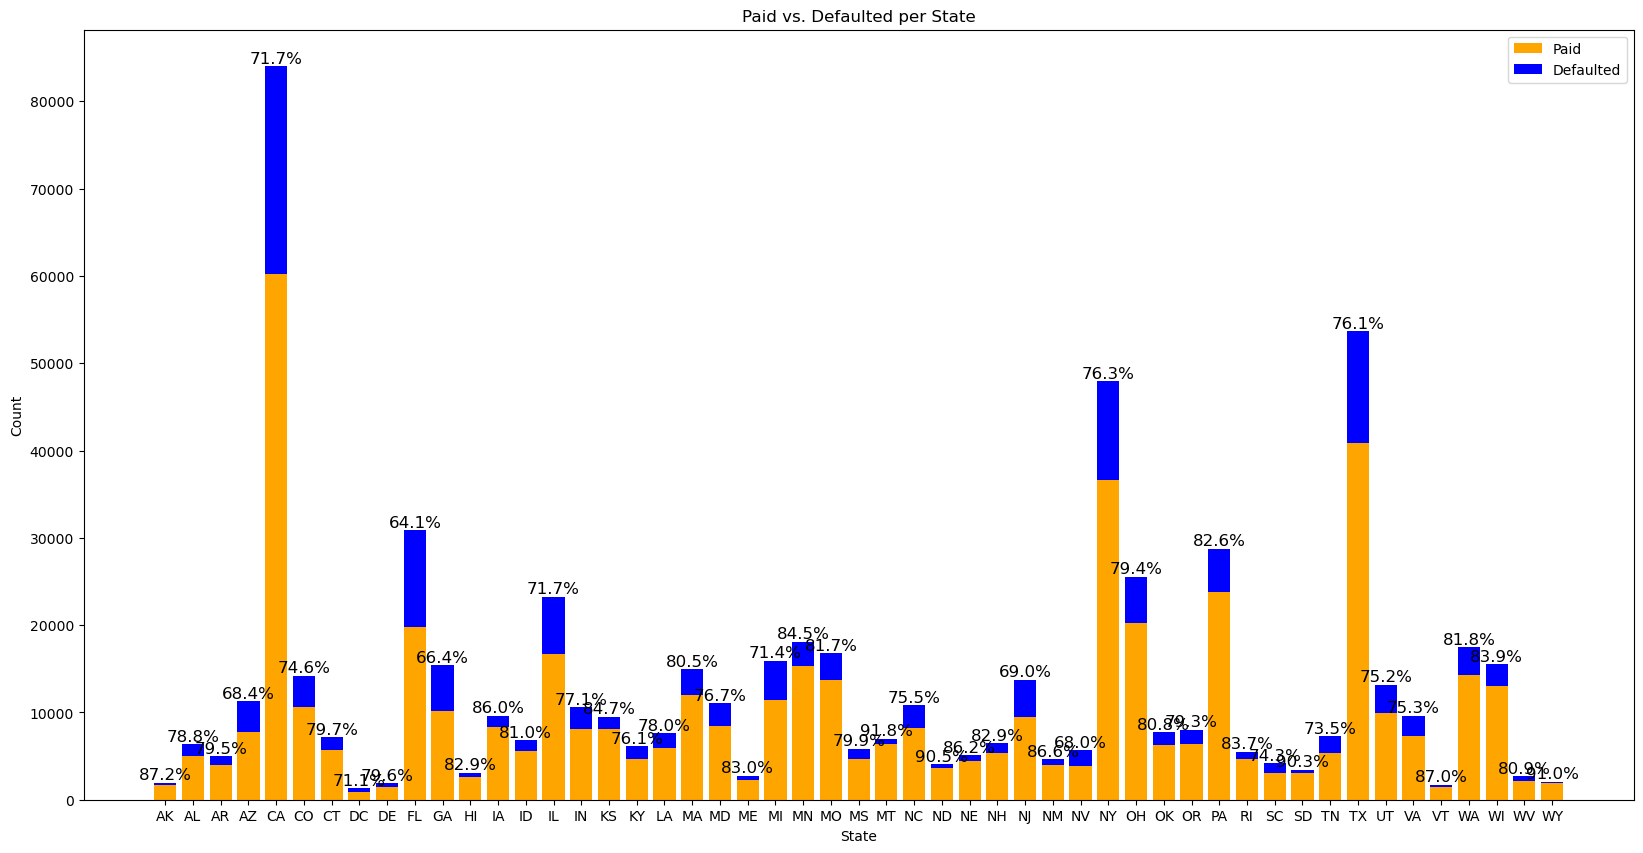

In [49]:
# group by State and show the value counts for paid per state
state_counts = eda_df.groupby('State')['Paid'].value_counts().unstack(fill_value=0)

# Get percent paid per state
state_counts['Percentage_Paid'] = state_counts[1] / (state_counts[1] + state_counts[0]) * 100

# Set figsize
fig, ax = plt.subplots(figsize=(20, 10))

# Set the width of each bar
bar_width = 0.8

# Create the bar for counts paid as the bottom half of bar. Set color and label
bar1 = ax.bar(range(51), state_counts[1], width=bar_width, color='orange', label='Paid')

# Create the bar for counts paid as the top half of bar. Set color and label
bar2 = ax.bar(range(51), state_counts[0], width=bar_width, bottom=state_counts[1], color='blue', label='Defaulted')

# Set the x-axis labels as state names
ax.set_xticks([x for x in range(51)])
ax.set_xticklabels(state_counts.index)

# Add labels and title
plt.xlabel('State')
plt.ylabel('Count')
plt.title('Paid vs. Defaulted per State')

# Add a legend
plt.legend()

# Add the percentage labels on top of each bar
for i in range(51):
    total_count = state_counts[1][i] + state_counts[0][i]
    percentage_paid = state_counts['Percentage_Paid'][i]
    ax.text(range(51)[i], total_count, f"{percentage_paid:.1f}%", ha='center', 
            va='bottom', fontsize=12);


The value counts per state ranged from 64.1%(Florida) to 91%(Wyoming). The vast majority of the values fell in the 70s and low 80s. The state with the most value counts was California, with over 80,000 loans given, which was followed by Texas and then New York, both with over 50,000.

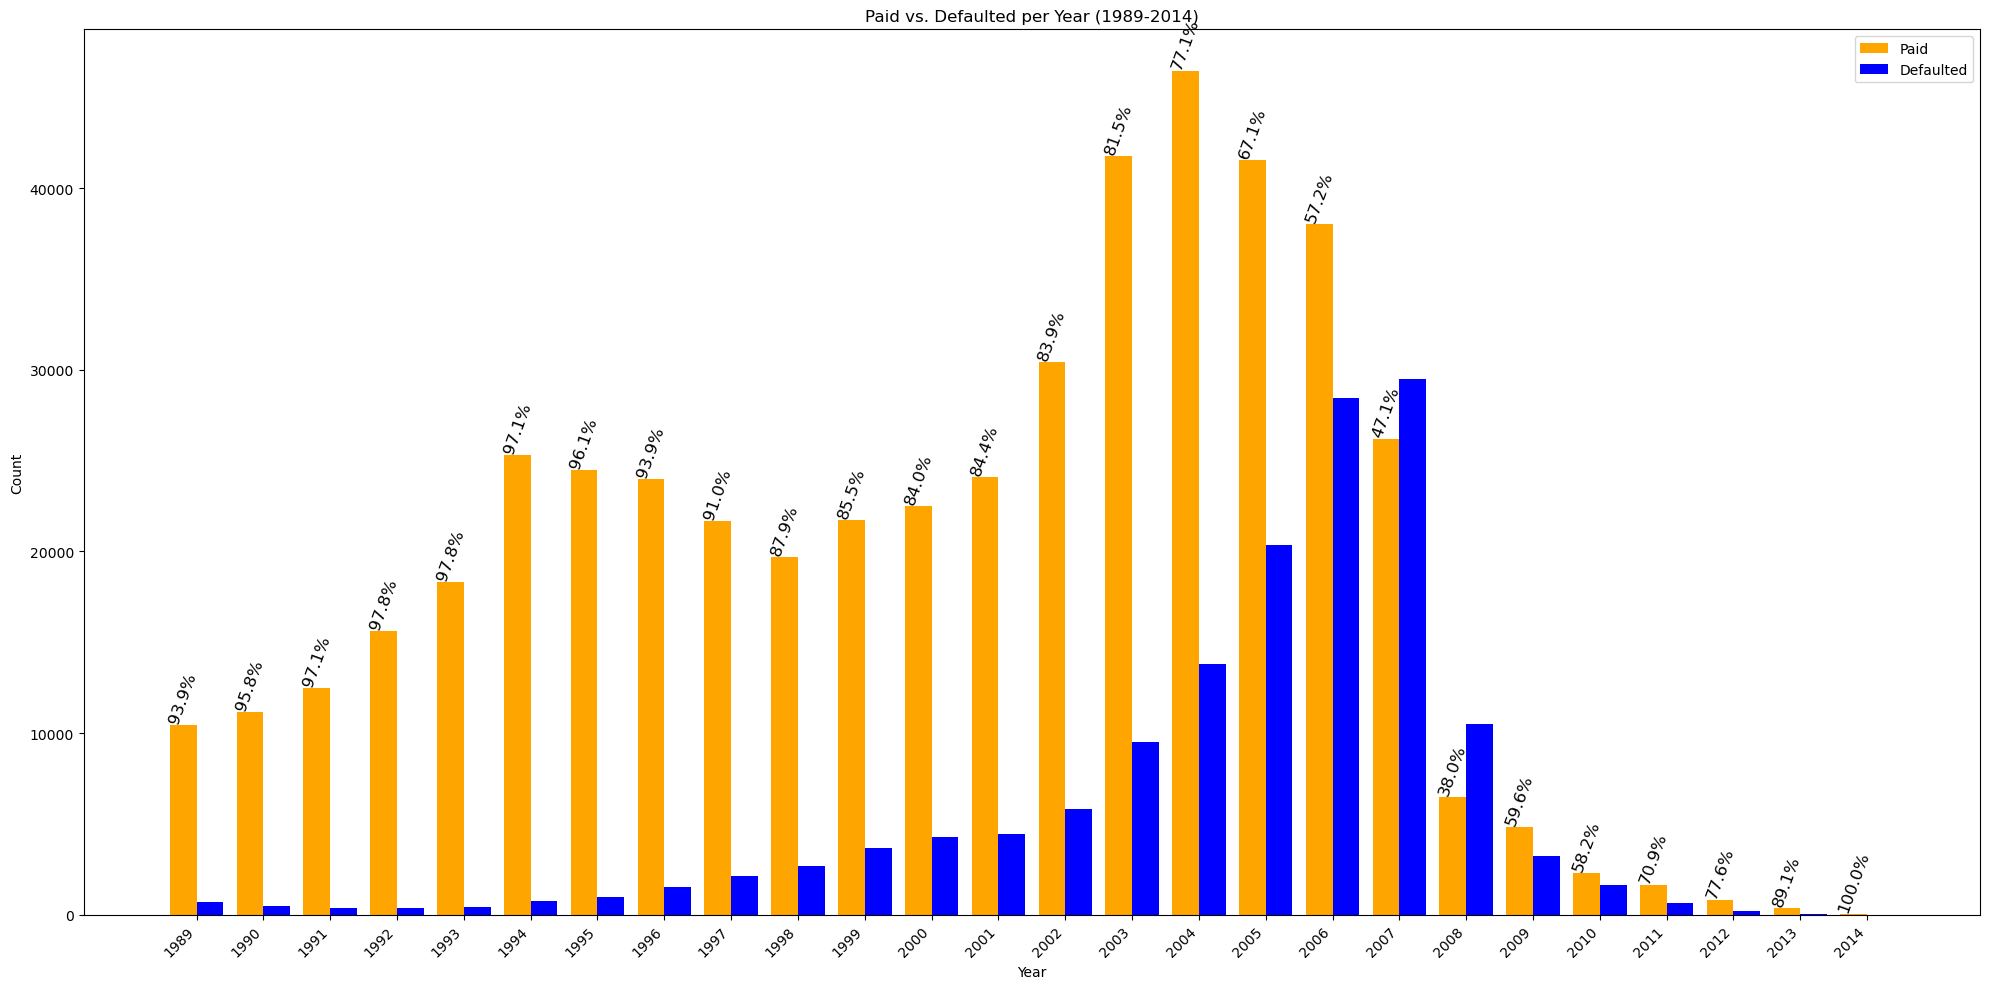

In [50]:
# only include data between 1989 to 2014
eda_df_filtered = eda_df[(eda_df['approval_year'] >= 1989) 
                         & (eda_df['approval_year'] <= 2014)]

# group by paid per year
year_counts = eda_df_filtered.groupby('approval_year')['Paid'].value_counts().unstack(
    fill_value=0)

# Get percent paid per year
year_counts['Percentage_Paid'] = year_counts[1] / (year_counts[1] + year_counts[0]) * 100

#set figsize
fig, ax = plt.subplots(figsize=(20, 10))

# Get the number of years for x-axis positions
num_years = len(year_counts)
x_positions = range(num_years)

# Set the width of each bar
bar_width = 0.4  

# Create the bar for counts paid. Set color and label
bar1 = ax.bar([x - bar_width / 2 for x in x_positions], year_counts[1], 
              width=bar_width, color='orange', label='Paid')

# Create the bar for counts defaulted. Set color and label
bar2 = ax.bar([x + bar_width / 2 for x in x_positions], year_counts[0], 
              width=bar_width, color='blue', label='Defaulted')

# Set the x-axis labels as years
ax.set_xticks([x for x in x_positions])
ax.set_xticklabels(year_counts.index, rotation=45, ha='right') 

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Paid vs. Defaulted per Year (1989-2014)')

# Add a legend
plt.legend()

# Add the percentage labels on top of each bar
for i in range(num_years):
    total_count = year_counts[1].iloc[i] + year_counts[0].iloc[i]
    percentage_paid = year_counts['Percentage_Paid'].iloc[i]
    ax.text(x_positions[i] - bar_width / 2, year_counts[1].iloc[i], f"{percentage_paid:.1f}%", ha='center', 
            va='bottom', rotation=70, fontsize=12)

plt.tight_layout();  # Ensures that all elements fit nicely in the figure area

Since the loan counts before 1989 were below 10,000 per year we are only graphing from 1989 and on. The number of loans distributed steadily increased from slightly above 10,000 in 1989 to over 60,000 in 2007. Additionally, the loan paid percentage also began to decrease over that time period. Where in 1990 it was 96% by 2004 it was 77%. From 2004 to 2008 the paid percentage decreased by roughly 10% per year, to 38% in 2008. This may be strongly related to the global financial crisis of 2007-2008. From 2008 and on the number of loans in out dataset steadily decreased, and the loan paid percentage also increased with it.

Now let's graph the spread of paid vs default in our boolean columns

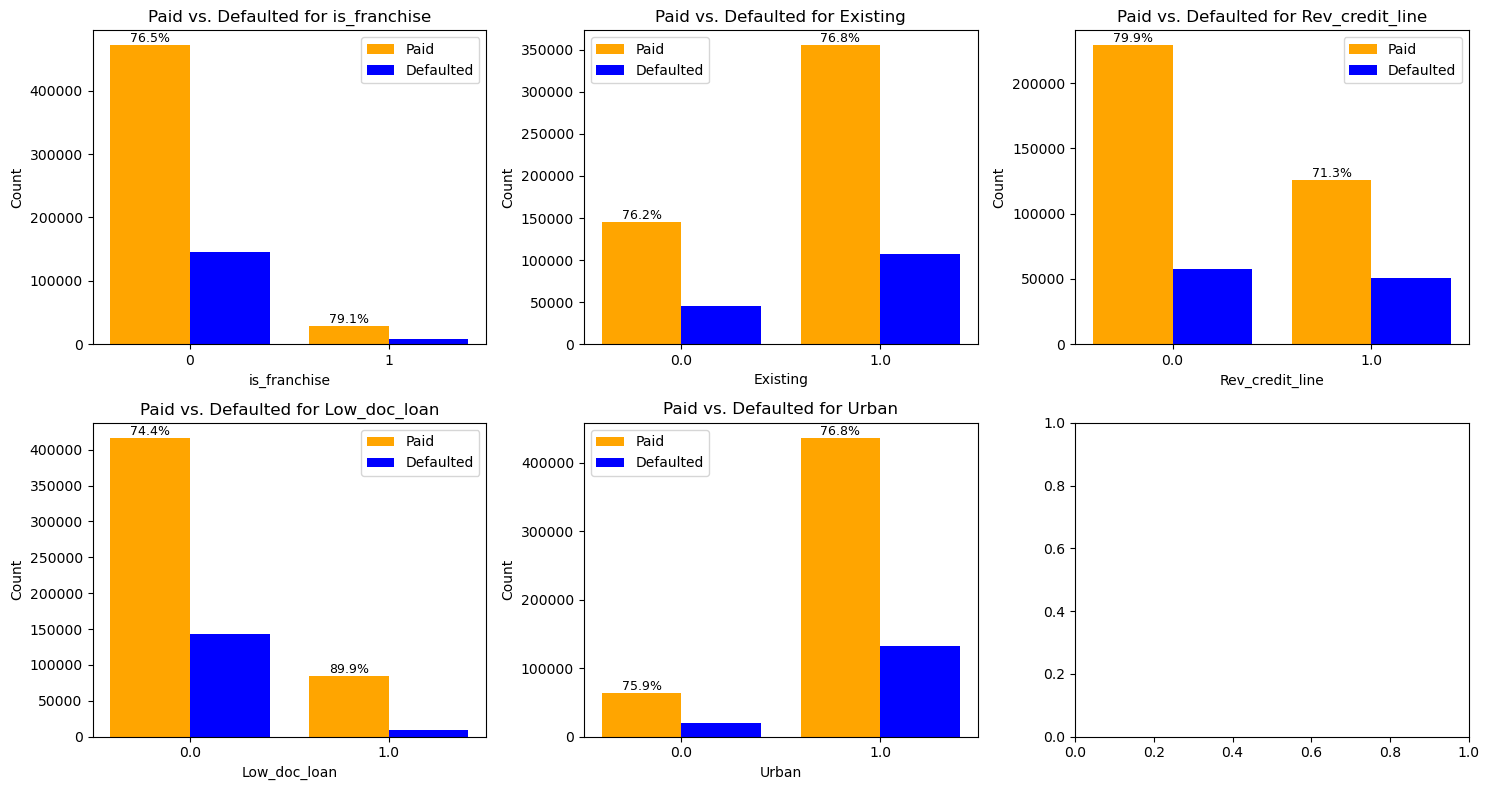

In [51]:
# Create list of columns to plot (remove one column from the original list)
columns = ['is_franchise', 'Existing', 'Rev_credit_line', 'Low_doc_loan', 'Urban']

# Set fig and axs
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

for col, ax in zip(columns, axs.flat):
    # Get counts per boolean column
    counts = eda_df.groupby(col)['Paid'].value_counts().unstack(fill_value=0)
    
    # Calculate the percentage of Paid loans for each value in the boolean column
    counts['Percent_paid'] = counts[1] / (counts[0] + counts[1]) * 100
    
    # Set x-axis positions for bars
    x_positions = range(len(counts.index))
    
    # Set the width of each bar
    bar_width = 0.4
    
    # Create the bar for Paid loans
    bar1 = ax.bar(x_positions, counts[1], width=bar_width, color='orange', label='Paid')
    
    # Create the bar for Defaulted loans
    bar2 = ax.bar([x + bar_width for x in x_positions], counts[0], width=bar_width, color='blue', label='Defaulted')
    
    # Set the x-axis labels as boolean values
    ax.set_xticks([x + bar_width / 2 for x in x_positions])
    ax.set_xticklabels(counts.index, rotation=0)
    
    # Add labels and title for each subplot
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.set_title(f'Paid vs. Defaulted for {col}')
    
    # Add a legend for each subplot
    ax.legend()
    
    # Add the percentage labels on top of each "Paid" bar
    for j in range(len(counts.index)):
        total_count = counts[1].iloc[j] + counts[0].iloc[j]
        percentage_paid = counts['Percent_paid'].iloc[j]
        ax.text(x_positions[j], counts[1].iloc[j] + 5, f"{percentage_paid:.1f}%", ha='center', va='bottom', fontsize=9)

plt.tight_layout();


For most of the graphs here the paid percentage is the same for each category. However, the biggest differences were for `Low_doc_loan` and `Rev_credit_line`. In that businesses that got there loans from the Low document loan program had a 15% higher paid percentage. Businesses without a revolving line of credit also had around a 9% higher paid percentage.

Now let's check out some of the correlations.

In [52]:
# Selecting only the numeric columns
numeric_cols = eda_df.select_dtypes(include=['float64', 'int64', 'Int64']) 

#convert data types to float
numeric_cols = numeric_cols.astype('float64')

#create correlation matrix
numeric_cols.corr()

,Term,NoEmp,CreateJob,RetainedJob,DisbursementGross,ChgOffPrinGr,GrAppv,SBA_Appv,approval_year,disbursement_year,loan_maturity_year,is_franchise,Existing,Rev_credit_line,Low_doc_loan,Paid,Urban
Term,1.000000,0.043030,0.056989,0.054103,0.273273,0.049322,0.324034,0.365736,-0.470356,-0.467885,0.281999,0.060342,0.000343,-0.340619,-0.008385,0.283147,0.054342
NoEmp,0.043030,1.000000,0.007408,0.012780,0.087644,0.011696,0.092660,0.093724,-0.059616,-0.058836,-0.029902,0.008250,0.032280,-0.042183,-0.016278,0.022849,0.011152
CreateJob,0.056989,0.007408,1.000000,0.996906,0.011463,0.008883,0.014106,0.022146,-0.073698,-0.072709,-0.033420,0.000760,0.003135,-0.026631,-0.014261,-0.009983,0.009469
RetainedJob,0.054103,0.012780,0.996906,1.000000,0.015152,0.010290,0.016780,0.023934,-0.067787,-0.066855,-0.029344,-0.000602,0.009104,-0.021276,-0.018164,-0.010465,0.009644
DisbursementGross,0.273273,0.087644,0.011463,0.015152,1.000000,0.376995,0.941438,0.910732,-0.141301,-0.140167,0.063808,0.045682,0.065720,-0.140091,-0.144020,0.025940,0.013104
ChgOffPrinGr,0.049322,0.011696,0.008883,0.010290,0.376995,1.000000,0.402255,0.375864,0.080788,0.078655,0.124672,0.041896,-0.015455,-0.052474,-0.071163,-0.429306,-0.010052
GrAppv,0.324034,0.092660,0.014106,0.016780,0.941438,0.402255,1.000000,0.979619,-0.203678,-0.202132,0.036612,0.062159,0.052048,-0.268411,-0.128232,0.035128,0.021710
SBA_Appv,0.365736,0.093724,0.022146,0.023934,0.910732,0.375864,0.979619,1.000000,-0.259215,-0.257107,0.009869,0.066954,0.042849,-0.310511,-0.106852,0.049432,0.026766
approval_year,-0.470356,-0.059616,-0.073698,-0.067787,-0.141301,0.080788,-0.203678,-0.259215,1.000000,0.995665,0.708920,-0.044219,-0.012096,0.518141,-0.172304,-0.280406,-0.160907
disbursement_year,-0.467885,-0.058836,-0.072709,-0.066855,-0.140167,0.078655,-0.202132,-0.257107,0.995665,1.000000,0.714994,-0.042940,-0.013544,0.521407,-0.171787,-0.274285,-0.160057


There is a lot going on in this plot. We see high correlation in the year columns with many other factors. This indicates that time has a major factor on loan defaults, or more accurately the external factors are definitely having an affect on businesses ability to pay back loans. We can also see that, as we noted above, term length and low doc loan programs have an affect on the status of loans

Let's pull up a pairplot of all our data. Being that its so large we will just take a small percentage of the data.

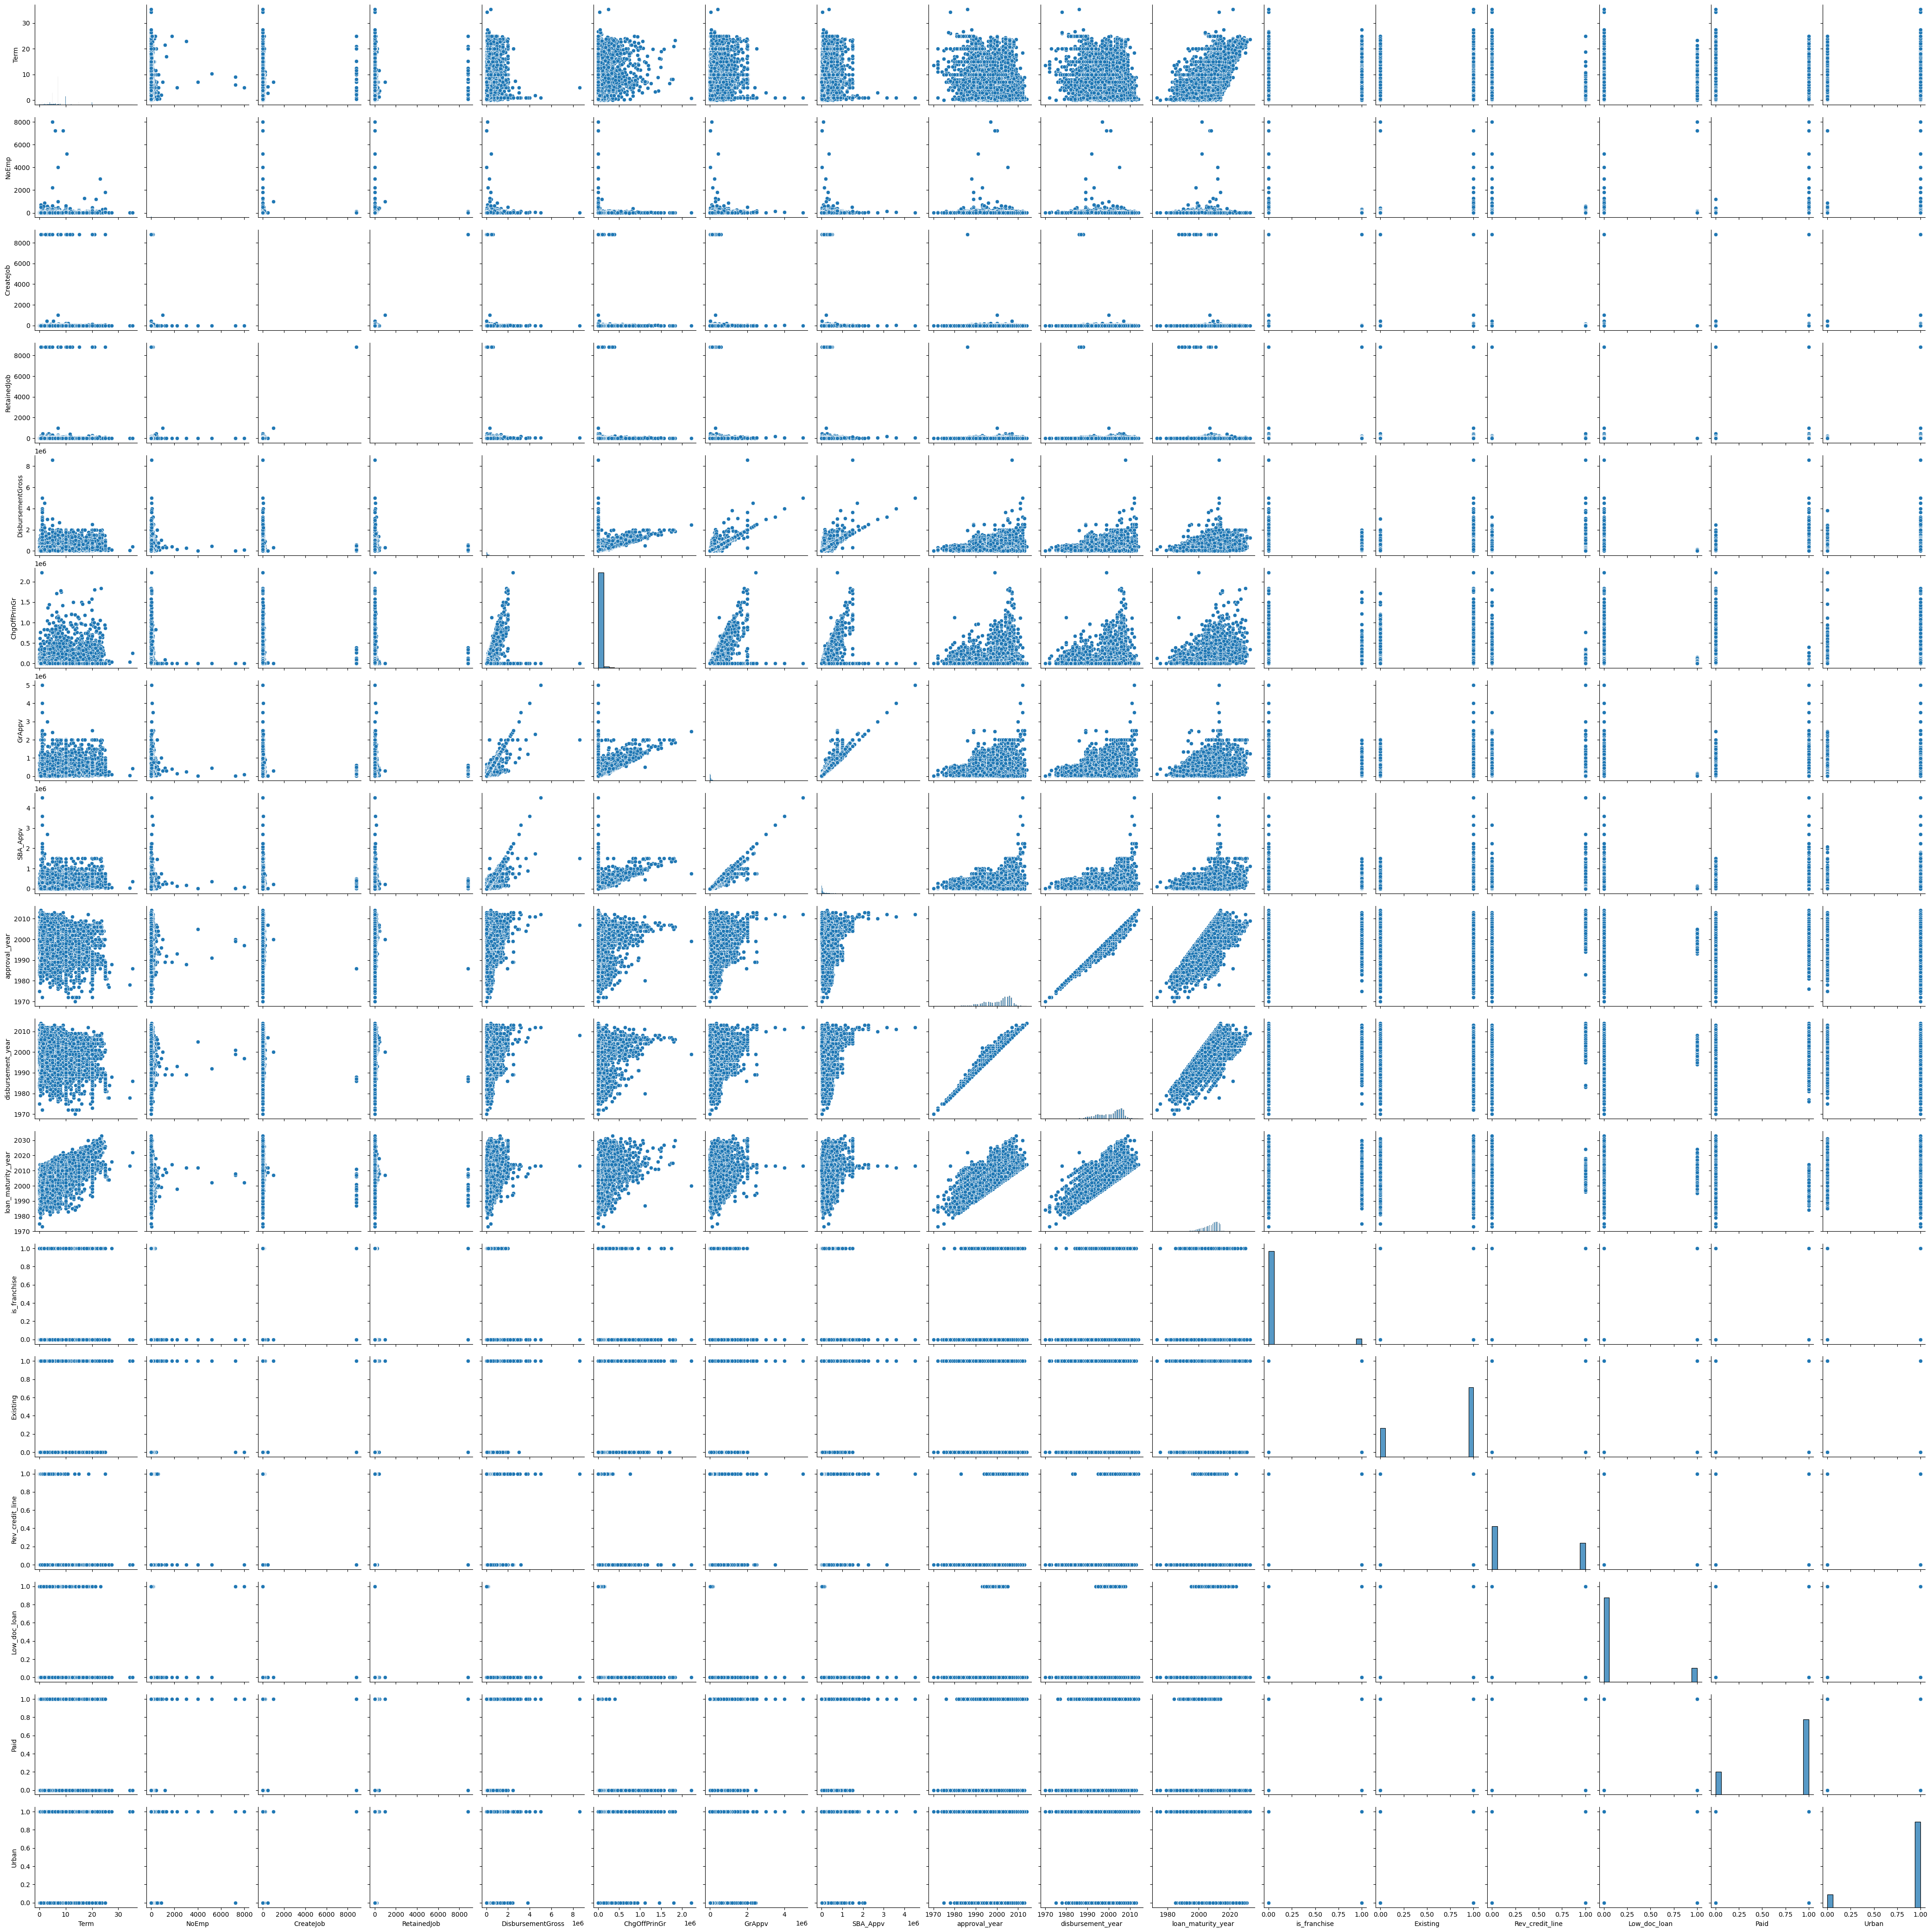

In [53]:
# Sample 50000 rows for visualization
subset_data = numeric_cols.sample(n=50000)  

# Create the pair plot with the subset of data
sns.pairplot(subset_data)
plt.show()

It is even harder to see what is going on here, especially since many of the plots are boolean columns. However, we can observe some correlations near the middle of the plot. We see that year columns have slight correlations with `GrAppv`, `SBA_Appv`, and `ChgOffPrinGr`.

Lets create a heatmap of our correlation data.

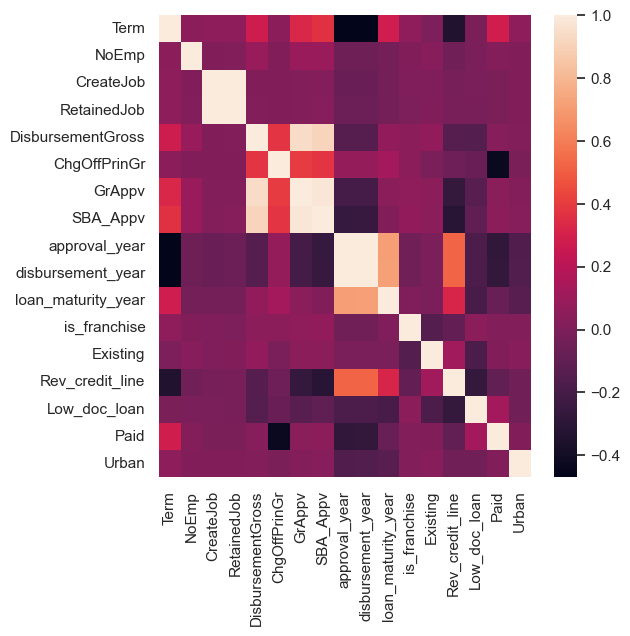

In [54]:
sns.set(rc = {'figure.figsize':(6,6)})

sns.heatmap(numeric_cols.corr());

A few more things stand out on this heatmap. Firstly we see that `DisbursementGross` has some correlation with the Appv columns we just listed. Additonally, the `Term` column has positive correlations with those columns, as well with `loan_maturity_year`; however, it has negative correlations with the year columns related to when the loan was given as well `Rev_credit_line`. 
Before we finish up our EDA, let's pull up correlations with just our target column, `Paid`.

In [55]:
#pull up correlations with the paid column
numeric_cols.corr()['Paid']

Term                  0.283147
NoEmp                 0.022849
CreateJob            -0.009983
RetainedJob          -0.010465
DisbursementGross     0.025940
ChgOffPrinGr         -0.429306
GrAppv                0.035128
SBA_Appv              0.049432
approval_year        -0.280406
disbursement_year    -0.274285
loan_maturity_year   -0.074344
is_franchise          0.014072
Existing              0.007225
Rev_credit_line      -0.098607
Low_doc_loan          0.128130
Paid                  1.000000
Urban                 0.007034
Name: Paid, dtype: float64

We will only take into account correlations that are around 10% and up. The highest correlation with `Paid` is `ChgOffPrinGr`, although this doesn't show us anything as the `ChgOff` column lists the amount that wasn't paid back on a defaulted loan. The next highest correlation was `Term`, which teaches us that the longer the term the better the odds that the loan gets paid back. Next we see that all the year columns have negative correlations with `Paid`, meaning that more recently less loans have been paid back. However, the time the loan was given has a greater affect on whether it will be paid back then when it is due. The last 2 observations we noted earlier from our boolean bar plots. We see that loans from the low doc program had a better chance that they will be paid back, and loans from businesses with a revolving credit line have a lower chance they will be paid back.

Now let's finish up our cleaning and move on to modeling

bar graph paid value counts
- map zipcodes on map of us. (marc)
- being that the loan count isnt the same every yr is there anyway to make a time graph?(marc)
    - date time graph: paid vs approval year?
    - arima models with paid and approval year(utube)
    - link to kaggle(explain in data understanding section)
    - open in colab(github--> search username--> dropdown file)
    - geopandas zipcode

In [56]:
beep = 

SyntaxError: invalid syntax (3017436297.py, line 1)

### Final preprocessing for modeling

Now that we have finished the EDA let's move on to our last cleaning steps before we start modeling

Pre-modeling after the eda: 
- ohe columns: Bank, BankState, NAICS, State. 
- drop: .drop(columns=['Zip', 'City', 'LoanNr_ChkDgt','approval_date', 'disbursement_date', 'chg_off_date','loan_maturity_date', 'Name'], axis=1)
- drop Rev_credit_line column
- center years
- undersample



Get dummy variables for str columns

In [ ]:
#create a function to make dummy cols
def dummy_cols_and_drop(df, column, new_drop_dummy_value):
    #create dummy columns
    encoded_cols = pd.get_dummies(df[column], prefix=column)
    
    #drop the unidentified column
    encoded_cols.drop(f'{column}_{new_drop_dummy_value}', axis=1, inplace=True)
    
    #Switch the values from T and F to 1 and 0
    encoded_cols = encoded_cols.astype(int)
    
    #concatenate new dummy loan_df with old loan_df.
    df = pd.concat([df.drop(column, axis=1), encoded_cols], axis=1)
    
    return df

In [ ]:
loan_df = dummy_cols_and_drop(loan_df, 'NAICS', 'Unidentified')
loan_df = dummy_cols_and_drop(loan_df, 'Bank', 'tiny')
#create dummy columns and drop the other column
loan_df = dummy_cols_and_drop(loan_df, 'BankState', 'other')

#create dummy columns and drop the DC column
loan_df = dummy_cols_and_drop(loan_df, 'State', 'DC')

In terms of dealing with the null values in `Rev_credit_line` let't try out a few different methods and run a very basic model to see how it does. First, we should do some EDA on the column to see if anything stands out. Maybe we can fill the null values in `Rev_credit_line` based on values in a different column that it highly correlates with. First lets pull up the null count again.

In [ ]:
#drop str columns
test_loan_df = loan_df.drop(columns=['LoanNr_ChkDgt','City', 'Zip', 'Name'], axis=1)
#pull up correlations
rev_corr = test_loan_df.corr()['Rev_credit_line']
#only show the first 20 rows, as the rest are dummy cols
rev_corr[:21]

We see that there is a somewhat strong correlation between `approval year` and `Rev_credit_line`, let's graph this

In [ ]:
#set wide figure size
plt.figure(figsize=(15, 6))  # Set a wider figure size (width, height)

#create a countplot
sns.countplot(x='approval_year', hue='Rev_credit_line', data=test_loan_df)

#plot labels
plt.xlabel('Approval Year')
plt.ylabel('Count')
plt.title('Distribution of Rev_credit_line across Approved Years')
plt.legend(title='Rev_credit_line', labels=['No', 'Yes'])

#rotate ticks to vertical so the values can be seen
plt.xticks(rotation=90); 

In [ ]:
# show Rev_credit_line by year
grouped_data = test_loan_df.groupby('approval_year')['Rev_credit_line'].mean()

pd.set_option('display.max_rows', None)
grouped_data

In [ ]:
#reset so it doesnt print all
pd.reset_option('display.max_rows')

Being that before the year 1994 there were almost no loans with a Revolving credit line, let's set all the null values before 1994 to 0.

In [ ]:
#fill null in approved year before 1994 with 0
loan_df.loc[loan_df['approval_year'] < 1994, 'Rev_credit_line'].fillna(0, inplace=True)

#check null count
loan_df.Rev_credit_line.isna().sum()

This removed almost no null counts! Let's see the null counts by year to see why that is so.

In [ ]:
loan_df.groupby('approval_year')['Rev_credit_line'].apply(lambda x: x.isna().sum())

We see that there was only 1 null count that occured before 1994. It clearly doesn't make sense to fill all the null counts with 0 eventhough it is the overall mode, as all the null counts were at a time where there was a higher ratio of 1s in that column. There even seems that there is a correlation between the null counts and the years that Rev_credit_line had a lot of yes values. Let's fill all the null values with 1 and run our first basic model. We'll also try creating dummy columns with the null counts to see how that does. Next, lets drop all the rows with null counts in the `Rev_credit_line` column and see how that does. Finally, we will drop the whole column to see if the model does better without it.

In [ ]:
#drop all string or datetime columns
fill_1_loan_df = loan_df.drop(columns=['LoanNr_ChkDgt','City', 'Zip', 'Name',
                                       'approval_date', 'disbursement_date',
                                       'loan_maturity_date'], axis=1)

#create second practice loan_df
dummy_loan_df = fill_1_loan_df.copy()

#create third practice df
drop_loan_df = fill_1_loan_df.copy()

#drop column
drop_col_loan_df = fill_1_loan_df.copy()

In [ ]:
# Method 1: fill all null values with 1
fill_1_loan_df.fillna(1, inplace=True)

# method 2: create dummy columns for 1, 0 and missing
dummy_loan_df.fillna('missing', inplace=True)

#use function from early to create dummy values
dummy_loan_df = dummy_cols_and_drop(dummy_loan_df, 'Rev_credit_line', 'missing')

#method 3: dropna values 
drop_loan_df.dropna(inplace=True)

#method 4: drop rev column
drop_col_loan_df.drop(columns='Rev_credit_line', axis=1, inplace=True)

In [ ]:
#create function to test performance
def run_dt(loan_df):
    #Set X and y
    X = loan_df.drop(columns=['Paid'])
    y = loan_df['Paid']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the Decision Tree Classifier
    clf = DecisionTreeClassifier(random_state=42)

    # Train the classifier on the training data
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Calculate the F1 score
    f1 = f1_score(y_test, y_pred)

    return print("F1 score:", f1)

In [ ]:
#create loan_df list
loan_df_list = [fill_1_loan_df, dummy_loan_df, drop_loan_df, drop_col_loan_df]

#run function on all trial dfs
for trial in loan_df_list:
    run_dt(trial)

Eventhough we haven't gotten to modeling, it is nice to see that we are doing a good job with the cleaning, given the extremely high F1 score. Before we set our change inplace we have one more cleaning step that may be affected by this change. Let's pull up our target column

In [ ]:
#preview Paid vc
print(loan_df.Paid.value_counts())
print(loan_df.Paid.value_counts(normalize=True))

We see that our dataset is slightly imbalanced, let's discuss a few different ways we can handle this. Being that we have a dataset with around 650 thousand rows and around 150 columns, it wouldnt be a good idea to use SMOTE on sauch a large dataset. Especially being that in this case the imbalance isn't that strong. it try to undersample the 1s and oversample the 0s, to see if that can improve our metrics. We will then run a basic decision tree model to see how it did. Instead, let's try using weights to see if that improves the f1 score as well as undersampling the target columns that paid back their loans.

First let's try using weights

In [ ]:
#drop null values as that performed the best
tester_df = loan_df.dropna()

In [ ]:
#drop columns that won't be used for model
tester_df = tester_df.drop(columns=['Zip', 'City', 'LoanNr_ChkDgt', 'approval_date', 
                                    'disbursement_date','loan_maturity_date', 'Name'], axis=1)

In [ ]:
#set X and y
X = tester_df.drop(columns=['Paid'])
y = tester_df['Paid']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#create list of weights and name them to check out
weights = [None, 'balanced', {1: 1, 0: 2}, {1: 1, 0: 3}, {1: 1, 0: 5}, {1: 10, 0: 1}]
names = ['None', 'Balanced', '1 to 2', '1 to 3', '1 to 5', '10 to 1']

for n, weight in enumerate(weights):
    # Fit model with weights
    dt = DecisionTreeClassifier(class_weight=weight, random_state=42)
    model_dt = dt.fit(X_train, y_train)

    # Predict 
    y_pred = dt.predict(X_test)
    
    # Calculate the F1 score
    f1 = f1_score(y_test, y_pred)

    #print score
    print('F1 score for {}: {}'.format(names[n], f1))
    print('-------------------------------------------------------------------------------------');

We see that the weights had a negative affect on the model's performance. As such let's move on and try undersampling. Being that one of our potential cleaning method drops a lot of rows, let's test out the affect on undersampling on our different potential cleaning methods for our `Rev_credit_line` column.

In [ ]:
df_list = [fill_1_loan_df, dummy_loan_df, drop_loan_df, drop_col_loan_df]

for index, df in enumerate(df_list):
    X = df.drop(columns=['Paid'])
    y = df['Paid']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    #initialize RandomUnderSampler
    rus = RandomUnderSampler(random_state=42)

    #resample
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

    #print value counts
    print(y_resampled.value_counts())

    # Initialize the Decision Tree Classifier
    clf = DecisionTreeClassifier(random_state=42)

    # Train the classifier on the training data
    clf.fit(X_resampled, y_resampled)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Calculate the F1 score
    f1 = f1_score(y_test, y_pred)

    print("F1 score:",f1)
    print();

The undersampling definitely improved our metrics as such we will set it inplace. Additionally, we see that the best method for cleaning is to drop the `Rev_credit_line` column. 

In [ ]:
loan_df.shape
#this shape does include bankstate and regular state that were ohe into 50 col each

B4 modeling deal with the class imbalance, undersample the larger side, and oversample with smote the smaller side. 

Also center the yr cols with the code below

In [ ]:
# Before we move let's offset all the year columns. Let's check out when is the first year of our data and subtract that number from all the year columns. Being that we will shortlyy drop the `chg_off_date` columns, we dont need to include it

# #create list of yr cols
# year_cols = ['disbursement_year', 'loan_maturity_year', 'approved_year']

# #create empty list
# years = []

# #fill year list with min years
# for col in year_cols:
#     years.append(min(loan_df[col]))
    
# #set the min of the years as min
# min_year = min(years)

# #print the minimum year
# print(min_year)

# #offset the year columns
# for col in year_cols:
#     loan_df[col] = loan_df[col] - min_year 

# #preview cols
# loan_df.approved_year.head()